In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses

In [4]:
!pip install transformers=='2.8.0'

In [5]:
import re
import os
import math
import torch
# import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, NLLLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
# from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW, XLNetTokenizer, XLNetModel, TFXLNetModel, XLNetLMHeadModel, XLNetConfig, XLNetForSequenceClassification
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.4.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
import pandas as pd

df_train = pd.read_csv('Constraint_English_Train.csv')
df_valid = pd.read_excel('Constraint_English_Val.xlsx')
df_test = pd.read_csv('Constraint_English_Test.csv')
df_test_labels = pd.read_excel('test_labels.xlsx')

df_train.head(1)

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real


In [8]:
df_train = pd.concat([df_train, df_valid])
df_valid = df_valid.loc[1:5]

In [9]:
print(df_train.shape)
print(df_valid.shape)
print(df_test.shape)
print(df_test_labels.shape)

(8560, 3)
(5, 3)
(2140, 2)
(2140, 3)


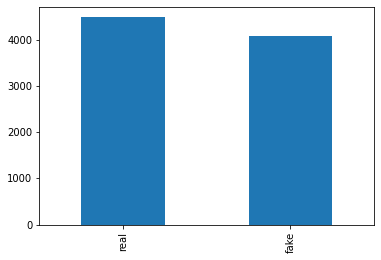

In [10]:
df_train['label'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [11]:
def clean_text(text):
    #Remove emojis and special chars
    clean=text
    reg = re.compile('\\.+?(?=\B|$)')
    clean = text.apply(lambda r: re.sub(reg, string=r, repl=''))
    reg = re.compile('\x89Û_')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl=' '))
    reg = re.compile('\&amp')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='&'))
    reg = re.compile('\\n')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl=' '))

    #Remove hashtag symbol (#)
    clean = clean.apply(lambda r: r.replace('#', ''))

    #Remove user names
    reg = re.compile('@[a-zA-Z0-9\_]+')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='@'))

    #Remove URLs
    reg = re.compile('https?\S+(?=\s|$)')
    clean = clean.apply(lambda r: re.sub(reg, string=r, repl='www'))

    #Lowercase
    clean = clean.apply(lambda r: r.lower())
    return clean

In [12]:
df_train['clean'] = clean_text(df_train['tweet'])
df_valid['clean'] = clean_text(df_valid['tweet'])
df_test['clean'] = clean_text(df_test['tweet'])
#df_all['clean'] = clean_text(df_all['tweet'])

In [13]:
# from transformers import TFXLNetModel, XLNetTokenizer

xlnet_model = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(xlnet_model)

In [14]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
df_train['label'] = LE.fit_transform(df_train['label'])
df_train.head(2)

,id,tweet,label,clean
0,1,The CDC currently reports 99031 deaths. In gen...,1,the cdc currently reports 99031 deaths in gene...
1,2,States reported 1121 deaths a small rise from ...,1,states reported 1121 deaths a small rise from ...


In [15]:
df_valid['label'] = LE.fit_transform(df_valid['label'])
df_valid.head(2)

,id,tweet,label,clean
1,2,11 out of 13 people (from the Diamond Princess...,0,11 out of 13 people (from the diamond princess...
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",0,"covid-19 is caused by a bacterium, not virus a..."


In [16]:
def get_labels(prediction):
    predicted_label =  LE.inverse_transform([prediction])
    return predicted_label[0]

get_labels(1)

'real'

In [17]:
df_train['label'].value_counts()

1    4480
0    4080
Name: label, dtype: int64

In [18]:
train_sentences = list(df_train.clean.values)
train_labels = list(df_train.label.values)

In [19]:
valid_sentences = list(df_valid.clean.values)
valid_labels = list(df_valid.label.values)

In [20]:
import pickle
import gzip
with gzip.open('lda_model_save', 'rb') as fp:
    lda_saved = pickle.load(fp)
dictionary=lda_saved[0]

In [21]:
import joblib
lda_model = joblib.load('lda_model')

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LatentDirichletAllocation from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [22]:
import os
import sys
import nltk
nltk.download('stopwords')
import csv
import math
import glob
import pickle
!pip install git+https://github.com/boudinfl/pke --timeout=10000

from sklearn.model_selection import GridSearchCV

# from pke.base import LoadFile

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def get_topic_embeddings(text):
  stoplist = stopwords.words('english')
  tf_vectorizer = CountVectorizer(stop_words=stoplist,
                                          vocabulary=dictionary)

  tf = tf_vectorizer.fit_transform(text)
  #topic document distribution
  distribution_topic_document = lda_model.transform(tf)
  return distribution_topic_document

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
  Cloning https://github.com/boudinfl/pke to /tmp/pip-req-build-9v4n9d9g
  Running command git clone -q https://github.com/boudinfl/pke /tmp/pip-req-build-9v4n9d9g
  Created wheel for pke: filename=pke-1.8.1-cp36-none-any.whl size=8763600 sha256=a02500f15567331f03e5c8d72409a3e74730fea91f5b13aaa5560f898fb062e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-pkv91fln/wheels/d8/70/e6/9a1235dad13c2f1de958195853b07b4fe2b11ef26dbbc23b7f
Successfully built pke


In [23]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
topic_embeddings_train = get_topic_embeddings(train_sentences)
topic_embeddings_train = torch.tensor(topic_embeddings_train,dtype=torch.float)
print(topic_embeddings_train.shape)

torch.Size([8560, 100])


In [25]:
topic_embeddings_val = get_topic_embeddings(valid_sentences)
topic_embeddings_val = torch.tensor(topic_embeddings_val,dtype=torch.float)
print(topic_embeddings_val.shape)

torch.Size([5, 100])


In [26]:
def tokenize_inputs(text_list, tokenizer, num_embeddings=120):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    return attention_masks

In [27]:
# Tokenize all of the sentences and map the tokens to thier word IDs. --- training set

input_ids_train = tokenize_inputs(train_sentences, tokenizer, num_embeddings=120)
attention_masks_train = create_attn_masks(input_ids_train)

input_ids_train = torch.from_numpy(input_ids_train)
attention_masks_train = torch.tensor(attention_masks_train)
train_labels = torch.tensor(train_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', train_sentences[1])
print('Token IDs:', input_ids_train[1])
print('Token IDs:', attention_masks_train[1])

Original:  states reported 1121 deaths a small rise from last tuesday southern states reported 640 of those deaths www
Token IDs: tensor([ 1035,   550,   506,  2306,  3945,    24,   316,  1735,    40,   129,
           17,  2853,   202,   765,  1335,  1035,   550,    17, 22205,    20,
          186,  3945,  2055,     4,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            

In [28]:

# Tokenize all of the sentences and map the tokens to thier word IDs. --- training set

input_ids_valid = tokenize_inputs(valid_sentences, tokenizer, num_embeddings=120)
attention_masks_valid = create_attn_masks(input_ids_valid)

input_ids_valid = torch.from_numpy(input_ids_valid)
attention_masks_valid = torch.tensor(attention_masks_valid)
valid_labels = torch.tensor(valid_labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', valid_sentences[1])
print('Token IDs:', input_ids_valid[1])
print('Token IDs:', attention_masks_valid[1])

Original:  covid-19 is caused by a bacterium, not virus and can be treated with aspirin
Token IDs: tensor([  830,  7791,    13,   815,    27,  1441,    37,    24, 29754,    19,
           50,  4294,    21,    64,    39,  3170,    33, 27506,     4,     3,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0, 

In [29]:
print(len(attention_masks_valid))

5


In [30]:
from torch.utils.data import TensorDataset, random_split

train_dataset = TensorDataset(input_ids_train, attention_masks_train, topic_embeddings_train, train_labels)
val_dataset = TensorDataset(input_ids_valid, attention_masks_valid, topic_embeddings_val, valid_labels)

# Calculate the number of samples to include in each set.
train_size = len(train_dataset)
val_size = len(val_dataset) 

# Checking whether the distribution of target is consitent across both the sets
label_temp_list = []
for a,b,c,d in train_dataset:
  label_temp_list.append(d)

print('{:>5,} training samples'.format(train_size))
print('{:>5,} training samples with real disater tweets'.format(sum(label_temp_list)))


label_temp_list = []
for a,b,c,d in val_dataset:
  label_temp_list.append(d)

print('{:>5,} validation samples'.format(val_size))
print('{:>5,} validation samples with real disater tweets'.format(sum(label_temp_list)))

8,560 training samples
4,480 training samples with real disater tweets
    5 validation samples
    2 validation samples with real disater tweets


In [31]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch import nn

batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [32]:
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
  def __init__(self, num_labels=2):
    super(XLNetForMultiLabelSequenceClassification, self).__init__()
    self.num_labels = num_labels
    self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased', output_attentions=True)
    self.linear = torch.nn.Linear(868,600)
    self.classifier = torch.nn.Linear(600, num_labels)

    torch.nn.init.xavier_normal_(self.classifier.weight)

  #def forward(self, input_ids, token_type_ids=None, attention_mask=None, topic_embed=None, labels=None):
  def forward(self, input_ids,topic_emb, token_type_ids=None, attention_mask=None, labels=None):
       
    # last hidden layer
    last_hidden_state = self.xlnet(input_ids=input_ids,\
                                   attention_mask=attention_mask,\
                                   token_type_ids=token_type_ids
                                  )
    #print(last_hidden_state[0].shape,topic_emb.shape)
    # print(len(last_hidden_state))
    # print(last_hidden_state)
    hidden = torch.mean(last_hidden_state[0],dim=1)
    concat_output = torch.cat((hidden, topic_emb), dim=1)
    # mean_last_hidden_state = self.pool_hidden_state(concat_output)
    output = self.linear(concat_output)
    logits = self.classifier(output)
    logits = logits[:, 1] - logits[:, 0]
    if labels is not None:
      loss = BCEWithLogitsLoss()(logits, labels.float())
#       loss = loss_fct(logits.view(-1, self.num_labels),\
#                       labels.view(-1, self.num_labels))
    
      return loss
    else:
      return logits, last_hidden_state[-1]
    
  def freeze_xlnet_decoder(self):
    """
    Freeze XLNet weight parameters. They will not be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = False
    
  def unfreeze_xlnet_decoder(self):
    """
    Unfreeze XLNet weight parameters. They will be updated during training.
    """
    for param in self.xlnet.parameters():
      param.requires_grad = True
    
  def pool_hidden_state(self, last_hidden_state):
    """
    Pool the output vectors into a single mean vector 
    """
    last_hidden_state = last_hidden_state[0]
    mean_last_hidden_state = torch.mean(last_hidden_state, 1)
    return mean_last_hidden_state
    
model = XLNetForMultiLabelSequenceClassification(num_labels=len(train_labels.unique()))

In [33]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                 weight_decay = 0.01,
                 correct_bias=False
                )

In [34]:
from torch import nn
loss_func = nn.CrossEntropyLoss()

import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [35]:
def train(model, num_epochs,\
          optimizer,\
          train_dataloader, valid_dataloader,\
          model_save_path,\
          train_loss_set=[], valid_loss_set = [],\
          lowest_eval_loss=None, start_epoch=0,\
          device="cpu"
          ):
  """
  Train the model and save the model with the lowest validation loss
  """
  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []
  # Measure the total training time for the whole run.
  total_t0 = time.time()

  model.to(device)

  # trange is a tqdm wrapper around the normal python range
  for i in trange(num_epochs, desc="Epoch"):
    # if continue training from saved model
    actual_epoch = start_epoch + i

    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set. 
    print("")
    print('======== Epoch {:} / {:} ========'.format(actual_epoch, num_epochs))
    print('Training...')
    
    # Measure how long the training epoch takes.
    t0 = time.time()
    
    # Set our model to training mode (as opposed to evaluation mode)
    model.train()

    # Tracking variables
    tr_loss = 0
    num_train_samples = 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_topic, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        #loss = model(input_ids=b_input_ids, attention_mask=b_input_mask, topic= b_topic, labels=b_labels)
        loss = model(b_input_ids,b_topic, attention_mask=b_input_mask,labels=b_labels)
        # store train loss
        tr_loss += loss.item()
        num_train_samples += b_labels.size(0)
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
        #scheduler.step()

    # Update tracking variables
    epoch_train_loss = tr_loss/num_train_samples
    train_loss_set.append(epoch_train_loss)

#     print("Train loss: {}".format(epoch_train_loss))
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(epoch_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
    
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()
    
    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss = 0
    num_eval_samples = 0

    # Evaluate data for one epoch
    for batch in valid_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_topic, b_labels = batch
        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate validation loss
            loss = model(b_input_ids,b_topic, attention_mask=b_input_mask,labels=b_labels)
            # store valid loss
            eval_loss += loss.item()
            num_eval_samples += b_labels.size(0)

    epoch_eval_loss = eval_loss/num_eval_samples
    valid_loss_set.append(epoch_eval_loss)

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(epoch_eval_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': actual_epoch,
            'Training Loss': epoch_train_loss,
            'Valid. Loss': epoch_eval_loss,
        #    'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

    
    if lowest_eval_loss == None:
      lowest_eval_loss = epoch_eval_loss
      # save model
      save_model(model, model_save_path, actual_epoch,\
                 lowest_eval_loss, train_loss_set, valid_loss_set)
    else:
      if epoch_eval_loss < lowest_eval_loss:
        lowest_eval_loss = epoch_eval_loss
        # save model
        save_model(model, model_save_path, actual_epoch,\
                   lowest_eval_loss, train_loss_set, valid_loss_set)
  
  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
  return model, train_loss_set, valid_loss_set, training_stats

In [36]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [37]:
def save_model(model, save_path, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist):
  """
  Save the model to the path directory provided
  """
  model_to_save = model.module if hasattr(model, 'module') else model
  checkpoint = {'epochs': epochs, \
                'lowest_eval_loss': lowest_eval_loss,\
                'state_dict': model_to_save.state_dict(),\
                'train_loss_hist': train_loss_hist,\
                'valid_loss_hist': valid_loss_hist
               }
  torch.save(checkpoint, save_path)
  print("Saving model at epoch {} with validation loss of {}".format(epochs,\
                                                                     lowest_eval_loss))
  return
  
def load_model(save_path):
  """
  Load the model from the path directory provided
  """
  checkpoint = torch.load(save_path)
  model_state_dict = checkpoint['state_dict']
  model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
  model.load_state_dict(model_state_dict)

  epochs = checkpoint["epochs"]
  lowest_eval_loss = checkpoint["lowest_eval_loss"]
  train_loss_hist = checkpoint["train_loss_hist"]
  valid_loss_hist = checkpoint["valid_loss_hist"]
  
  return model, epochs, lowest_eval_loss, train_loss_hist, valid_loss_hist

In [38]:
torch.cuda.empty_cache()

In [39]:
num_epochs = 15

cwd = os.getcwd()
model_save_path = output_model_file = os.path.join(cwd, "/xlnet_tweet.bin")
# os.mkdir('xlnet_tweet')

# model_save_path = '/content/drive/My Drive/Disaster_Tweets/XLNet_tweet_classification_model/xlnet_tweet.bin'
model, train_loss_set, valid_loss_set, training_stats = train(model=model,\
                                                              num_epochs=num_epochs,\
                                                              optimizer=optimizer,\
                                                              train_dataloader=train_dataloader,\
                                                              valid_dataloader=validation_dataloader,\
                                                              model_save_path=model_save_path,\
                                                              device="cuda"
                                                              )

Epoch:   0%|          | 0/15 [00:00<?, ?it/s]


======== Epoch 0 / 15 ========
Training...


/usr/local/lib/python3.6/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


  Batch    40  of    268.    Elapsed: 0:00:37.
  Batch    80  of    268.    Elapsed: 0:01:13.
  Batch   120  of    268.    Elapsed: 0:01:49.
  Batch   160  of    268.    Elapsed: 0:02:26.
  Batch   200  of    268.    Elapsed: 0:03:02.
  Batch   240  of    268.    Elapsed: 0:03:39.

  Average training loss: 0.01
  Training epcoh took: 0:04:04

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00


Epoch:   7%|▋         | 1/15 [04:05<57:18, 245.62s/it]

Saving model at epoch 0 with validation loss of 0.00015018096892163157

======== Epoch 1 / 15 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:36.
  Batch    80  of    268.    Elapsed: 0:01:13.
  Batch   120  of    268.    Elapsed: 0:01:49.
  Batch   160  of    268.    Elapsed: 0:02:26.
  Batch   200  of    268.    Elapsed: 0:03:02.
  Batch   240  of    268.    Elapsed: 0:03:39.


Epoch:  13%|█▎        | 2/15 [08:09<53:05, 245.07s/it]


  Average training loss: 0.00
  Training epcoh took: 0:04:04

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00

======== Epoch 2 / 15 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:36.
  Batch    80  of    268.    Elapsed: 0:01:13.
  Batch   120  of    268.    Elapsed: 0:01:49.
  Batch   160  of    268.    Elapsed: 0:02:25.
  Batch   200  of    268.    Elapsed: 0:03:01.
  Batch   240  of    268.    Elapsed: 0:03:38.

  Average training loss: 0.00
  Training epcoh took: 0:04:02

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00


Epoch:  20%|██        | 3/15 [12:13<48:57, 244.76s/it]

Saving model at epoch 2 with validation loss of 4.909605486318469e-05

======== Epoch 3 / 15 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:36.
  Batch    80  of    268.    Elapsed: 0:01:12.
  Batch   120  of    268.    Elapsed: 0:01:48.
  Batch   160  of    268.    Elapsed: 0:02:23.
  Batch   200  of    268.    Elapsed: 0:03:00.
  Batch   240  of    268.    Elapsed: 0:03:36.

  Average training loss: 0.00
  Training epcoh took: 0:04:01

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00


Epoch:  27%|██▋       | 4/15 [16:16<44:46, 244.20s/it]

Saving model at epoch 3 with validation loss of 3.16417746944353e-05

======== Epoch 4 / 15 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:36.
  Batch    80  of    268.    Elapsed: 0:01:12.
  Batch   120  of    268.    Elapsed: 0:01:48.
  Batch   160  of    268.    Elapsed: 0:02:24.
  Batch   200  of    268.    Elapsed: 0:03:00.
  Batch   240  of    268.    Elapsed: 0:03:35.

  Average training loss: 0.00
  Training epcoh took: 0:04:00

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00


Epoch:  33%|███▎      | 5/15 [20:17<40:33, 243.39s/it]

Saving model at epoch 4 with validation loss of 4.7683712978141555e-09

======== Epoch 5 / 15 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:35.
  Batch    80  of    268.    Elapsed: 0:01:11.
  Batch   120  of    268.    Elapsed: 0:01:46.
  Batch   160  of    268.    Elapsed: 0:02:22.
  Batch   200  of    268.    Elapsed: 0:02:57.
  Batch   240  of    268.    Elapsed: 0:03:34.


Epoch:  40%|████      | 6/15 [24:16<36:18, 242.02s/it]


  Average training loss: 0.00
  Training epcoh took: 0:03:59

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00

======== Epoch 6 / 15 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:36.
  Batch    80  of    268.    Elapsed: 0:01:12.
  Batch   120  of    268.    Elapsed: 0:01:48.
  Batch   160  of    268.    Elapsed: 0:02:24.
  Batch   200  of    268.    Elapsed: 0:03:00.
  Batch   240  of    268.    Elapsed: 0:03:36.


Epoch:  47%|████▋     | 7/15 [28:17<32:12, 241.53s/it]


  Average training loss: 0.00
  Training epcoh took: 0:04:00

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00

======== Epoch 7 / 15 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:36.
  Batch    80  of    268.    Elapsed: 0:01:11.
  Batch   120  of    268.    Elapsed: 0:01:47.
  Batch   160  of    268.    Elapsed: 0:02:22.
  Batch   200  of    268.    Elapsed: 0:02:57.
  Batch   240  of    268.    Elapsed: 0:03:34.


Epoch:  53%|█████▎    | 8/15 [32:15<28:05, 240.73s/it]


  Average training loss: 0.00
  Training epcoh took: 0:03:59

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00

======== Epoch 8 / 15 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:36.
  Batch    80  of    268.    Elapsed: 0:01:13.
  Batch   120  of    268.    Elapsed: 0:01:49.
  Batch   160  of    268.    Elapsed: 0:02:26.
  Batch   200  of    268.    Elapsed: 0:03:02.
  Batch   240  of    268.    Elapsed: 0:03:39.


Epoch:  60%|██████    | 9/15 [36:20<24:10, 241.76s/it]


  Average training loss: 0.00
  Training epcoh took: 0:04:04

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00

======== Epoch 9 / 15 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:37.
  Batch    80  of    268.    Elapsed: 0:01:13.
  Batch   120  of    268.    Elapsed: 0:01:50.
  Batch   160  of    268.    Elapsed: 0:02:26.
  Batch   200  of    268.    Elapsed: 0:03:03.
  Batch   240  of    268.    Elapsed: 0:03:39.


Epoch:  67%|██████▋   | 10/15 [40:24<20:12, 242.52s/it]


  Average training loss: 0.00
  Training epcoh took: 0:04:04

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00

======== Epoch 10 / 15 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:36.
  Batch    80  of    268.    Elapsed: 0:01:13.
  Batch   120  of    268.    Elapsed: 0:01:50.
  Batch   160  of    268.    Elapsed: 0:02:26.
  Batch   200  of    268.    Elapsed: 0:03:03.
  Batch   240  of    268.    Elapsed: 0:03:39.


Epoch:  73%|███████▎  | 11/15 [44:28<16:12, 243.03s/it]


  Average training loss: 0.00
  Training epcoh took: 0:04:04

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00

======== Epoch 11 / 15 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:36.
  Batch    80  of    268.    Elapsed: 0:01:13.
  Batch   120  of    268.    Elapsed: 0:01:49.
  Batch   160  of    268.    Elapsed: 0:02:26.
  Batch   200  of    268.    Elapsed: 0:03:02.
  Batch   240  of    268.    Elapsed: 0:03:38.


Epoch:  80%|████████  | 12/15 [48:32<12:09, 243.19s/it]


  Average training loss: 0.00
  Training epcoh took: 0:04:04

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00

======== Epoch 12 / 15 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:36.
  Batch    80  of    268.    Elapsed: 0:01:13.
  Batch   120  of    268.    Elapsed: 0:01:49.
  Batch   160  of    268.    Elapsed: 0:02:26.
  Batch   200  of    268.    Elapsed: 0:03:02.
  Batch   240  of    268.    Elapsed: 0:03:38.


Epoch:  87%|████████▋ | 13/15 [52:34<08:05, 242.99s/it]


  Average training loss: 0.00
  Training epcoh took: 0:04:02

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00

======== Epoch 13 / 15 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:36.
  Batch    80  of    268.    Elapsed: 0:01:12.
  Batch   120  of    268.    Elapsed: 0:01:47.
  Batch   160  of    268.    Elapsed: 0:02:23.
  Batch   200  of    268.    Elapsed: 0:02:59.
  Batch   240  of    268.    Elapsed: 0:03:35.


Epoch:  93%|█████████▎| 14/15 [56:34<04:02, 242.00s/it]


  Average training loss: 0.00
  Training epcoh took: 0:04:00

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00

======== Epoch 14 / 15 ========
Training...
  Batch    40  of    268.    Elapsed: 0:00:36.
  Batch    80  of    268.    Elapsed: 0:01:13.
  Batch   120  of    268.    Elapsed: 0:01:49.
  Batch   160  of    268.    Elapsed: 0:02:25.
  Batch   200  of    268.    Elapsed: 0:03:02.
  Batch   240  of    268.    Elapsed: 0:03:38.


Epoch: 100%|██████████| 15/15 [1:00:37<00:00, 242.48s/it]


  Average training loss: 0.00
  Training epcoh took: 0:04:03

Running Validation...
  Validation Loss: 0.00
  Validation took: 0:00:00

Training complete!
Total training took 1:00:41 (h:mm:ss)


In [40]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
0,7.61e-03,1.50e-04,0:04:04,0:00:00
1,1.85e-03,4.52e-04,0:04:04,0:00:00
2,7.83e-04,4.91e-05,0:04:02,0:00:00
3,6.74e-04,3.16e-05,0:04:01,0:00:00
4,1.61e-04,4.77e-09,0:04:00,0:00:00
5,1.18e-04,1.23e-05,0:03:59,0:00:00
6,1.55e-04,7.15e-08,0:04:00,0:00:00
7,1.71e-04,1.85e-05,0:03:59,0:00:00
8,2.95e-04,4.86e-06,0:04:04,0:00:00


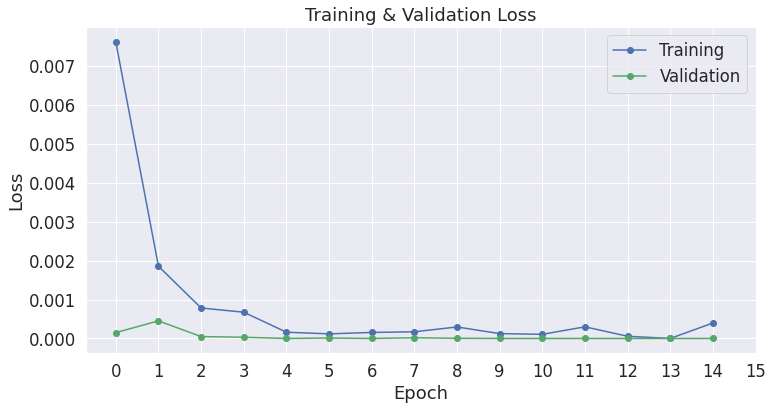

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([0, 1, 2, 3, 4, 5,6,7,8,9,10,11,12,13,14,15])

plt.show()

In [42]:
sentences_valid = df_valid.clean.values

val_input_ids = tokenize_inputs(sentences_valid, tokenizer, num_embeddings=120)
val_attention_masks = create_attn_masks(val_input_ids)
val_topic_embeddings = get_topic_embeddings(sentences_valid)

df_valid["features"] = val_input_ids.tolist()
df_valid["masks"] = val_attention_masks
df_valid["topic_embeddings"] = val_topic_embeddings.tolist()

In [43]:
def generate_predictions(model, df, device="cpu", batch_size=16):
  num_iter = math.ceil(df.shape[0]/batch_size)
  print(df.shape[0])
  pred_probs = []

  model.to(device)
  model.eval()
  
  for i in range(num_iter):
    df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
    X = df_subset["features"].values.tolist()
    masks = df_subset["masks"].values.tolist()
    topic_embed = df_subset["topic_embeddings"].values.tolist()
    X = torch.tensor(X)
    masks = torch.tensor(masks, dtype=torch.long)
    topic_embed = torch.tensor(topic_embed, dtype=torch.float)
    X = X.to(device)
    masks = masks.to(device)
    topic_embed = topic_embed.to(device)
    with torch.no_grad():
      logits,_ = model(X, topic_embed, attention_mask=masks)
      logits = logits.sigmoid().detach().cpu().numpy()
#       pred_probs = np.vstack([pred_probs, logits])
      pred_probs.extend(logits.tolist())
        
  return pred_probs


In [44]:
pred_probs = generate_predictions(model, df_valid, device="cuda", batch_size=16)
len(pred_probs)
# import statistics
# statistics.mean(pred_probs)

5


5

In [45]:
df_valid['label_pred'] = pred_probs
df_valid['label_pred'] = np.array(df_valid['label_pred'] >= 0.5, dtype='int')
df_valid.head(2)

,id,tweet,label,clean,features,masks,topic_embeddings,label_pred
1,2,11 out of 13 people (from the Diamond Princess...,0,11 out of 13 people (from the diamond princess...,"[506, 78, 20, 646, 104, 17, 10, 6127, 18, 8703...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0008333333333391602, 0.0008333333333391602,...",0
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",0,"covid-19 is caused by a bacterium, not virus a...","[830, 7791, 13, 815, 27, 1441, 37, 24, 29754, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0016666666666687356, 0.0016666666666687356,...",0


In [46]:
y_true = df_valid['label'].values
y_pred = df_valid['label_pred'].values
print(y_true[:10])
print(y_pred[:10])

[0 0 0 1 1]
[0 0 0 1 1]


In [47]:
from sklearn.metrics import precision_recall_fscore_support

print(precision_recall_fscore_support(y_true, y_pred, average='micro'))

(1.0, 1.0, 1.0, None)


In [48]:
from sklearn.metrics import precision_recall_fscore_support

print(precision_recall_fscore_support(y_true, y_pred, average='macro'))

(1.0, 1.0, 1.0, None)


In [49]:
from sklearn.metrics import precision_recall_fscore_support

print(precision_recall_fscore_support(y_true, y_pred, average='weighted'))

(1.0, 1.0, 1.0, None)


In [50]:
sentences_test = df_test.clean.values

test_input_ids = tokenize_inputs(sentences_test, tokenizer, num_embeddings=120)
test_attention_masks = create_attn_masks(test_input_ids)
test_topic_embeddings = get_topic_embeddings(sentences_test)

df_test["features"] = test_input_ids.tolist()
df_test["masks"] = test_attention_masks
df_test["topic_embeddings"] = test_topic_embeddings.tolist()

In [51]:
pred_probs = generate_predictions(model, df_test, device="cuda", batch_size=16)
# pred_probs
import statistics
statistics.mean(pred_probs)

2140


0.5315590274209795

In [58]:
df_test['target'] = pred_probs
df_test['target'] = np.array(df_test['target'] >= 0.5, dtype='int')

label = []

for x in df_test['target']:
  if x==1:
    label.append('real')
  elif (x==0):
    label.append('fake')

df_test['label'] = label
df_test[['id', 'label']].to_csv('answer.txt', index=False)
df_test.head(2)

,id,tweet,clean,features,masks,topic_embeddings,target,label
0,1,Our daily update is published. States reported...,our daily update is published states reported ...,"[120, 1362, 4835, 27, 901, 1035, 550, 425, 348...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0007142857142879405, 0.0007142857142879405,...",1,real
1,2,Alfalfa is the only cure for COVID-19.,alfalfa is the only cure for covid-19,"[1296, 9939, 2819, 27, 18, 114, 8461, 28, 830,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0025000000000001293, 0.0025000000000001293,...",0,fake


In [ ]:
import pandas as pd

answer = pd.read_csv('/content/drive/My Drive/NLP_MIDSEM/DebugEntity_2.csv')
answer.head(2)

,id,label
0,1,real
1,2,fake


In [59]:
true_labels = list(df_test_labels['label'])
predicted_labels = list(df_test['label'].values)
print(true_labels) 
print(predicted_labels)

['real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'real', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'fake', 'real', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'fake', 'fake', 'real', 'fake', 'real', 'real', 'real', 'real', 'real', 'real', 'fake', 'real', 'fake', 'real', 'real', 'fake', 'real', 'fake', 'fake', 'real', 'real', 'fake', 'real', 'real',

In [60]:
true_labels = LE.fit_transform(true_labels)
predicted_labels = LE.fit_transform(predicted_labels)
print(true_labels)
print(predicted_labels)

[1 0 0 ... 1 1 1]
[1 0 0 ... 1 1 1]


In [61]:
def get_labels(prediction):
    predicted_label =  LE.inverse_transform([prediction])
    return predicted_label[0]

get_labels(0)

'fake'

In [62]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    
    # precision = (true positives / (true positives+false positives))
    precision = precision_score(y_test, y_predicted, pos_label=None, average='weighted')             
    
    # recall = (true positives / (true positives + false negatives))
    recall = recall_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    
    return accuracy, precision, recall, f1


In [63]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(true_labels, predicted_labels)
accuracy, precision, recall, f1 = get_metrics(true_labels, predicted_labels)
print("Accuracy Score:", accuracy)
conf_mat

Accuracy Score: 0.9686915887850467


array([[ 977,   43],
       [  24, 1096]])

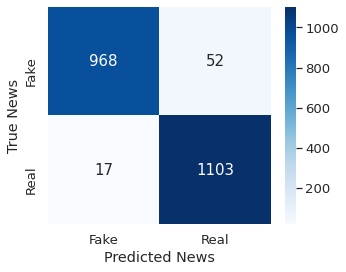

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(conf_mat)
fig = plt.figure(figsize=(5,4))
class_names= ['Fake', 'Real']
ax = sn.set(font_scale=1.2) # for label size
ax = sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, cmap=plt.cm.Blues, fmt='g') # font size
ax.set(xlabel='Predicted News', ylabel='True News')
# labels, title and ticks
ax.xaxis.set_ticklabels(['Fake', 'Real']); ax.yaxis.set_ticklabels(['Fake', 'Real']);
fig.show()

In [65]:
mc =0
for i in range(len(true_labels)):
  if true_labels[i]==predicted_labels[i]:
    continue
  mc+=1 

In [66]:
mc

67

In [67]:
from collections import Counter
fake_count=Counter()
real_count=Counter()

In [68]:
for i in range(len(df_train)):
  if df_train.iloc[i]['label']==1:
    for word in df_train.iloc[i]['clean'].strip().split():
      real_count[word]+=1
  else:
      for word in df_train.iloc[i]['clean'].strip().split():
        fake_count[word]+=1 

In [ ]:
misclassification={'fr':set(),'rf':set()}
stoplist = set(stopwords.words('english'))
for i in range(len(true_labels)):
  if true_labels[i]==predicted_labels[i]:
    continue
  id_ = answer.iloc[i]['id']
  if true_labels[i]==0 and predicted_labels[i]==1:
    misclassification['fr'].add(id_)
  elif true_labels[i]==1 and predicted_labels[i]==0:
    misclassification['rf'].add(id_)

In [ ]:
misclassification

In [ ]:
for i in misclassification['fr']:
  print("\n\n",i,"FR",df_test.iloc[i]['clean'])
  print("WORD FAKE REAL")
  for word in df_test.iloc[i]['clean'].strip().split():
    # if word not in stoplist:
      print(word, fake_count.get(word,"N/A"), real_count.get(word,"N/A"))



 1536 FR high alert: chicken infected from corona virus found in bangalore today, kindly circulate the message and avoid consumption of chicken spread to your dear ones
WORD FAKE REAL
high 30 148
alert: 4 N/A
chicken 7 N/A
infected 106 44
from 641 845
corona 162 25
virus 270 95
found 83 34
in 1919 3225
bangalore 7 N/A
today, 5 N/A
kindly 4 14
circulate 4 N/A
the 3768 5459
message 51 3
and 1341 2228
avoid 32 29
consumption 6 N/A
of 2021 4055
chicken 7 N/A
spread 77 212
to 2140 3309
your 150 290
dear 7 N/A
ones 6 25


 1921 FR maharashtra (19522) contributed 22.31% of the new recoveries while the states of andhra pradesh (12.24%) karnataka (8.3%) tamil nadu (6.31%) and chhattisgarh (6.0%) followed with 32.8% of the new recoveries these states together contribute 55.1% of total new recoveries www
WORD FAKE REAL
maharashtra 18 57
(19522) N/A N/A
contributed 1 13
22.31% N/A N/A
of 2021 4055
the 3768 5459
new 280 1143
recoveries 5 176
while 58 100
the 3768 5459
states 75 590
of 2021 4055
a

In [ ]:
for i in misclassification['rf']:
  print("\n\n",i,"RF",df_test.iloc[i]['clean'])
  print("WORD FAKE REAL")
  for word in df_test.iloc[i]['clean'].strip().split():
    # if word not in stoplist:
      print(word, fake_count.get(word,"N/A"), real_count.get(word,"N/A"))



 706 RF writer sees book sales soar as coronavirus spreads www duncanwhitehead coronavirus
WORD FAKE REAL
writer 2 N/A
sees 4 6
book 8 2
sales 6 N/A
soar 1 N/A
as 382 805
coronavirus 1590 371
spreads 6 8
www 1672 4190
duncanwhitehead N/A N/A
coronavirus 1590 371


 1218 RF the photo shows bedding and food aid packages distributed in rwanda during the coronavirus pandemic
WORD FAKE REAL
the 3768 5459
photo 65 N/A
shows 177 74
bedding N/A N/A
and 1341 2228
food 50 16
aid 5 3
packages 2 1
distributed 8 8
in 1919 3225
rwanda 1 N/A
during 159 113
the 3768 5459
coronavirus 1590 371
pandemic 243 117


 197 RF 📢coronavirusupdates: 📍covid19 india tracker (as on 23 september 2020 08:00 am) ➡️confirmed cases: 5646010 ➡️recovered: 4587613 (81.3%)👍 ➡️active cases: 968377 (17.2%) ➡️deaths: 90020 (1.6%) indiafightscorona indiawillwin staysafe via @ www
WORD FAKE REAL
📢coronavirusupdates: N/A 45
📍covid19 N/A 22
india 221 279
tracker 2 31
(as N/A 50
on 636 933
23 7 31
september 5 128
2020 71 199
08:0

In [ ]:
import sys
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo


In [ ]:
from bertviz import head_view

In [ ]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [ ]:
torch.save(model.state_dict(), os.path.join('NLP_VIZ', 'model_weights'))

In [ ]:
model = XLNetForMultiLabelSequenceClassification(num_labels=len(train_labels.unique()))

In [ ]:
model.load_state_dict(torch.load('NLP_VIZ/model_weights'))

In [ ]:
text = np.asarray([df_test.iloc[662]['clean']])
test_input_ids = tokenize_inputs(text, tokenizer, num_embeddings=120)
test_attention_masks = create_attn_masks(test_input_ids)
tokens = tokenizer.convert_ids_to_tokens(test_input_ids[0])
test_topic_embeddings = torch.tensor(get_topic_embeddings(text),dtype=torch.float)
test_input_ids=torch.tensor(test_input_ids,dtype=torch.long)
attention = model(test_input_ids, test_topic_embeddings)[-1]
new_attention=attention[7][0][7][:11][:,:11]
new_attention=new_attention.reshape(1,1,1,11,11)
print(new_attention.shape)
call_html()
head_view(new_attention, tokens[:11])

2
torch.Size([1, 1, 1, 11, 11])


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
for i in range(11):
  print("-------")
  # print(tokens[i])
  sum = 0
  for j in range(11):
    if i ==1 or i ==2 or i ==10 or i==9:
      sum+=new_attention[0][0][0][i][j].detach().numpy()
    # print(tokens[j],new_attention[0][0][0][i][j])
  if sum:
    print(tokens[i],sum)
# new_attention

-------
-------
▁co 0.49318649352062494
-------
vid 0.5017339250043733
-------
-------
-------
-------
-------
-------
-------
▁health 0.2513111923180986
-------
▁effects 0.06598534201839357


In [ ]:
new_attention[0][0][0][i][j].detach().numpy()

1.0432384088635445

In [ ]:
tokens[:33]

['▁chronic',
 '▁co',
 'vid',
 '-',
 '19',
 '▁has',
 '▁long',
 '-',
 'lasting',
 '▁health',
 '▁effects',
 '▁www',
 '<sep>',
 '<cls>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>',
 '<unk>']

In [ ]:
len(tokens[:2])

120

In [ ]:
len(new_attention.shape)

4

In [ ]:
os.mkdir('NLP_VIZ')

In [ ]:
model=XLNetForMultiLabelSequenceClassification()

In [ ]:
df_test.iloc[662]['target']

1

In [ ]:
df_test.columns

Index(['id', 'tweet', 'clean', 'features', 'masks', 'topic_embeddings',
       'target', 'label'],
      dtype='object')